In [75]:
import rasterio

filepath = 'downloads/S2A_MSIL2A_20210716T095031_N0301_R079_T34UEF_20210716T120258.SAFE/GRANULE/L2A_T34UEF_A031679_20210716T095359/IMG_DATA/R10m/T34UEF_20210716T095031'

dataset = rasterio.open(filepath + '_B03_10m.jp2')
dataset2 = rasterio.open(filepath + '_B08_10m.jp2')

array([[643, 658, 645, ..., 659, 655, 685],
       [628, 638, 676, ..., 676, 688, 694],
       [585, 616, 665, ..., 716, 692, 722],
       ...,
       [760, 778, 756, ..., 483, 558, 511],
       [727, 745, 730, ..., 510, 518, 523],
       [738, 741, 708, ..., 520, 521, 474]], dtype=uint16)

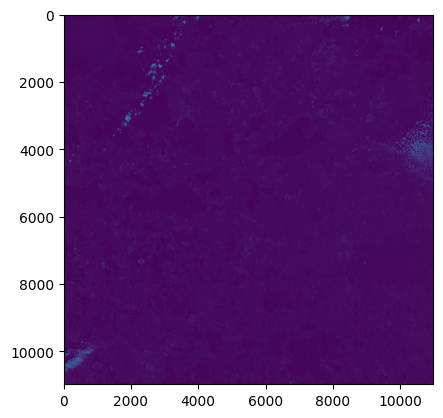

In [76]:
import matplotlib.pyplot as plt

image_band_1 = dataset.read(1)
plt.imshow(image_band_1)
image_band_1

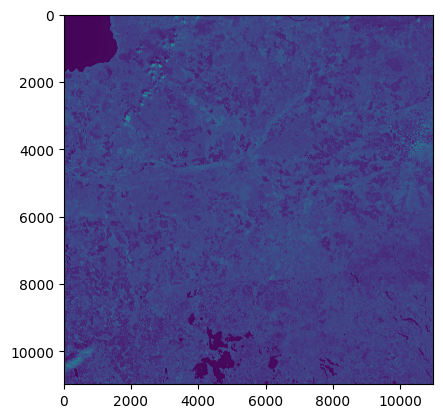

In [77]:
image_band_2 = dataset2.read(1)
plt.imshow(image_band_2)

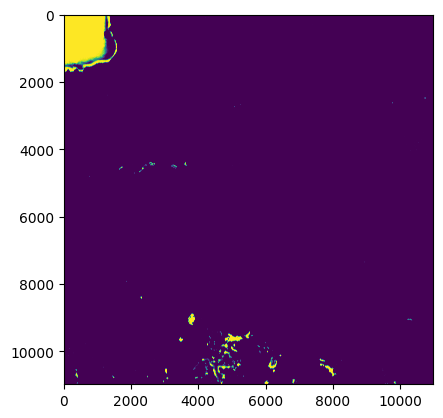

In [78]:
import numpy as np

# map 0 - ~16000 to 0.0 - 1.0
image_band_1_norm = image_band_1 / np.max(np.abs(image_band_1))
image_band_2_norm = image_band_2 / np.max(np.abs(image_band_2))

# 1 or 0 (water or not)
image_ndwi = (image_band_1_norm - image_band_2_norm) // (image_band_1_norm + image_band_2_norm + np.ones((image_band_1_norm.shape[0], image_band_1_norm.shape[1]))) + np.ones((image_band_1_norm.shape[0], image_band_1_norm.shape[1]))

# water mask true or false
water_mask = image_ndwi > 0.0

# show
plt.imshow(image_ndwi.astype('uint16'))

Opening file downloads/S2A_MSIL2A_20210716T095031_N0301_R079_T34UEF_20210716T120258.SAFE/GRANULE/L2A_T34UEF_A031679_20210716T095359/IMG_DATA/R10m/T34UEF_20210716T095031_B02_10m.jp2
Opening file downloads/S2A_MSIL2A_20210716T095031_N0301_R079_T34UEF_20210716T120258.SAFE/GRANULE/L2A_T34UEF_A031679_20210716T095359/IMG_DATA/R10m/T34UEF_20210716T095031_B03_10m.jp2
Opening file downloads/S2A_MSIL2A_20210716T095031_N0301_R079_T34UEF_20210716T120258.SAFE/GRANULE/L2A_T34UEF_A031679_20210716T095359/IMG_DATA/R10m/T34UEF_20210716T095031_B04_10m.jp2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


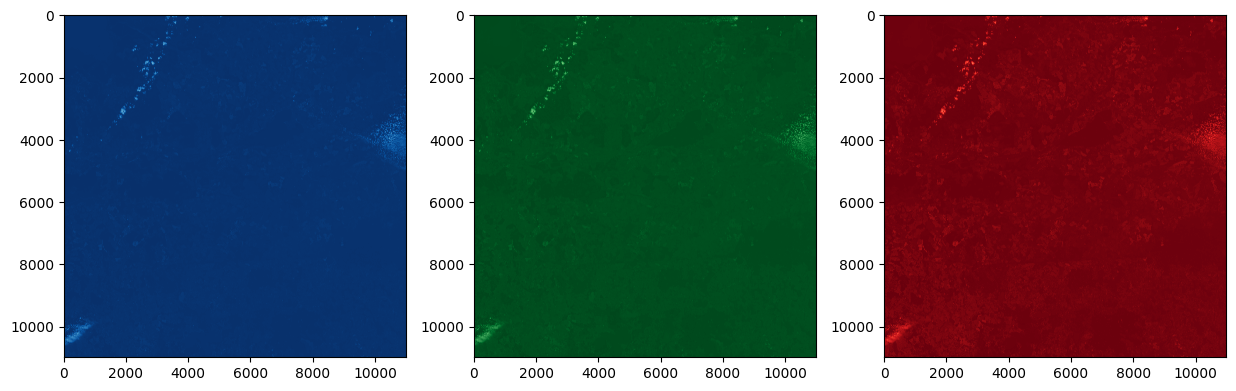

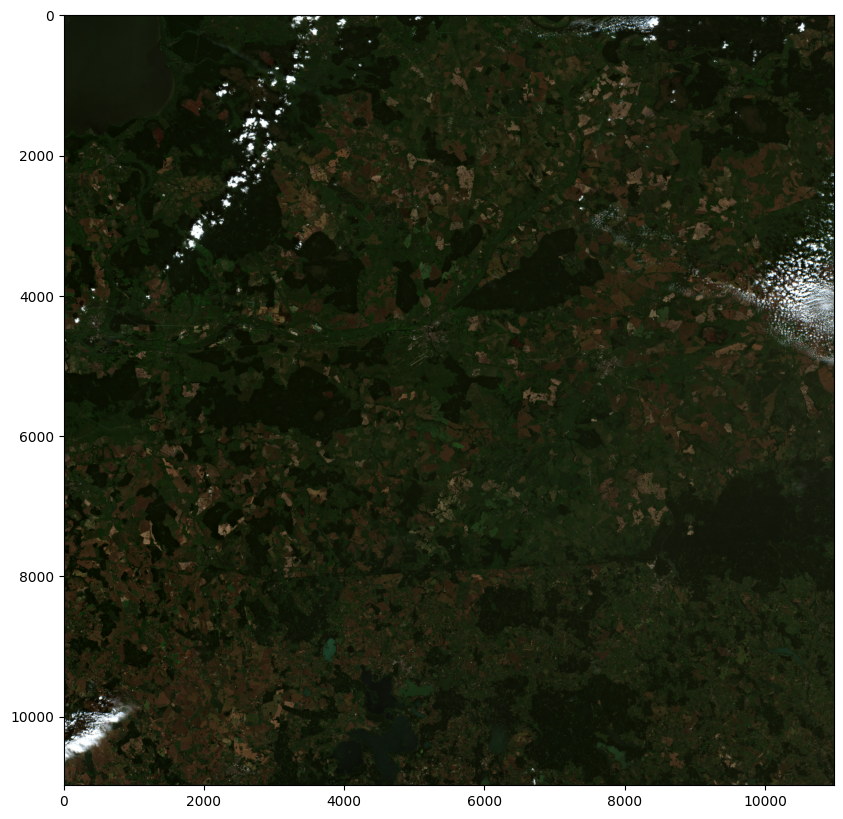

In [79]:
def load_sentinel_image(img_folder, filename, bands, scale):
    image = {}
    for band in bands:
        file = img_folder + 'R' + scale + 'm/' + filename + '_' + band + '_' + scale + 'm.jp2'
        print(f'Opening file {file}')
        ds = rasterio.open(file)
        image.update({band: ds.read(1)})

    return image


def display_rgb(img, b_r, b_g, b_b, alpha = 1., figsize = (10, 10)):
    rgb = np.stack([img[b_r], img[b_g], img[b_b]], axis = -1)
    rgb = rgb / rgb.max() * alpha
    plt.figure(figsize = figsize)
    plt.imshow(rgb)


img = load_sentinel_image(filepath[:filepath.index("IMG_DATA") + 9], filepath[filepath.index("IMG_DATA") + 14:], ['B02', 'B03', 'B04'], '10')

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].imshow(img['B02'], cmap = 'Blues_r')
ax[1].imshow(img['B03'], cmap = 'Greens_r')
ax[2].imshow(img['B04'], cmap = 'Reds_r')

display_rgb(img, 'B04', 'B03', 'B02', alpha = 5.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


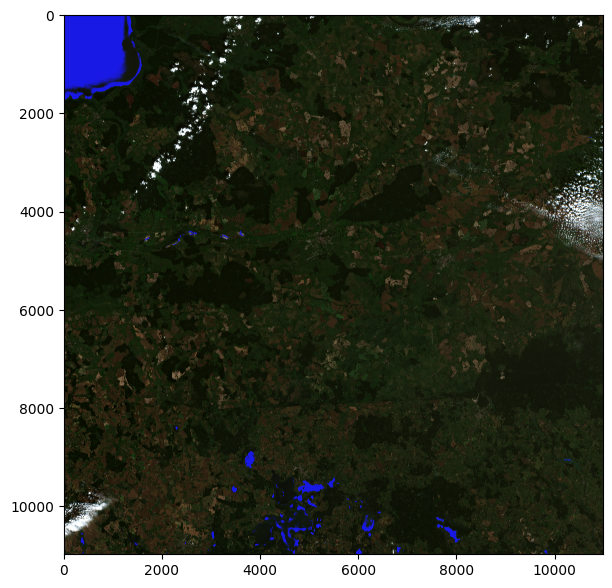

In [80]:
def new_water_mask_downscale(old_mask, old_shape, new_shape):
    new_mask = np.full((new_shape, new_shape), False)
    for i in range(new_shape):
        for j in range(new_shape):
            new_mask[i][j] = old_mask[(old_shape // new_shape) * i][(old_shape // new_shape) * j]
    
    return new_mask

rgb = np.stack([img['B04'], img['B03'], img['B02']], axis = -1)
rgb = rgb / rgb.max() * 5.

if (water_mask.shape[0] != rgb.shape[0]):
    water_mask = new_water_mask_downscale(water_mask, water_mask.shape[0], rgb.shape[0])

rgb[water_mask] = [0.1, 0.1, 0.9]

plt.figure(figsize = (7, 7))
plt.imshow(rgb)

In [83]:
from sklearn.cluster import DBSCAN
water_indexes = np.transpose(water_mask.nonzero())
clusters = DBSCAN(eps = 5.0, min_samples = 10).fit(water_indexes)
clusters.labels_

array([  0,   0,   0, ..., 199, 199, 199], dtype=int64)

In [84]:
# Filter no-clusters and small clusters
cluster_threshold = 10000
unique, counts = np.unique(clusters.labels_, return_counts = True)
cluster_indexes = dict(zip(unique, counts))
cluster_indexes_above_thre = {k: v for k, v in cluster_indexes.items() if v > cluster_threshold and k != -1}
cluster_indexes_above_thre

{0: 1891140,
 54: 42996,
 59: 14051,
 64: 83508,
 85: 11617,
 99: 13119,
 108: 34831,
 124: 24515,
 134: 40986,
 148: 35149}

In [87]:
cluster_mask = [idx in cluster_indexes_above_thre for idx in clusters.labels_]
water_indexes_image_coords = water_indexes[cluster_mask]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


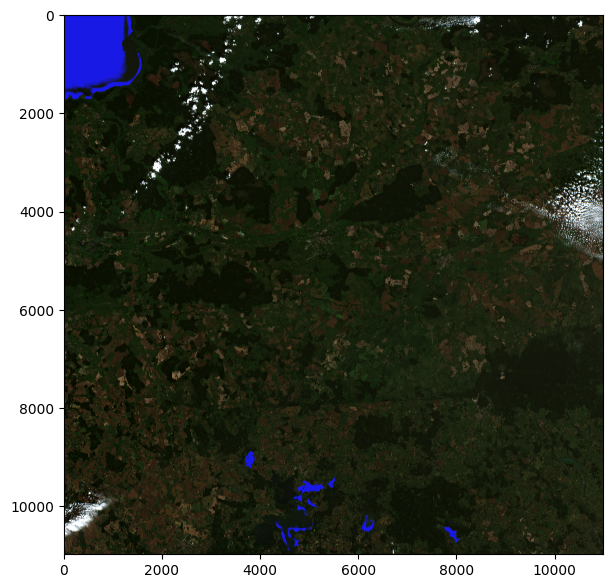

In [89]:
rgb = np.stack([img['B04'], img['B03'], img['B02']], axis=-1)
rgb = rgb/rgb.max() * 5

X = water_indexes_image_coords[:, 0]
Y = water_indexes_image_coords[:, 1]
mask_matrix = np.zeros((10980, 10980), dtype='bool')
mask_matrix[X, Y] = True
mask_matrix
rgb[mask_matrix] = [0.1, 0.1, 0.9]

plt.figure(figsize = (7,7))
plt.imshow(rgb)

In [90]:
print(mask_matrix)
print(water_indexes_image_coords)

[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[[    0     0]
 [    0     1]
 [    0     2]
 ...
 [10908  4595]
 [10908  4596]
 [10909  4593]]


In [93]:
data_transform = dataset.transform
move_to_real_coords = lambda water_idx: data_transform * water_idx
water_indexes_real_coords = np.array([move_to_real_coords(xi) for xi in water_indexes])

print(water_indexes_real_coords)
print(clusters.labels_)
zipped_water_clusters = zip(water_indexes_real_coords, clusters.labels_)
water_cluster_points = {}
for point, cluster_idx in zipped_water_clusters:
    if cluster_idx not in water_cluster_points:
        water_cluster_points[cluster_idx] = point
    
print(len(water_cluster_points))

[[ 499980. 6100020.]
 [ 499980. 6100010.]
 [ 499980. 6100000.]
 ...
 [ 609770. 6001420.]
 [ 609770. 6001400.]
 [ 609770. 6001390.]]
[  0   0   0 ... 199 199 199]
210


In [94]:
import fiona
from shapely.geometry import Point, mapping

schema = {'geometry': 'Point', 'properties': {'idx': 'int'}}

with fiona.open('shp/punkty.shp', 'w', crs = dataset.crs.to_wkt(), driver = 'ESRI Shapefile', schema = schema) as output:
    for idx, coordinates in water_cluster_points.items():
        point = Point(float(coordinates[0]), float(coordinates[1]))
        prop = {'idx': int(idx)}
        output.write({'geometry': mapping(point), 'properties': prop})

# sprawdzenie
c = fiona.open('shp/punkty.shp', 'r')
print(len(c))
print(next(iter(c)))
print(c.crs)
print(c[100])

210
{'type': 'Feature', 'id': '0', 'properties': OrderedDict([('idx', 0)]), 'geometry': {'type': 'Point', 'coordinates': (499980.0, 6100020.0)}}
{'init': 'epsg:32634'}
{'type': 'Feature', 'id': '100', 'properties': OrderedDict([('idx', 99)]), 'geometry': {'type': 'Point', 'coordinates': (599870.0, 6052300.0)}}
